In [26]:
import pandas as pd
from pathlib import Path
import pickle
from collections import defaultdict
import numpy as np
from pprint import pprint

from single import Wrapper

Plan:

1. visualize how important `[weight_decay, lr, dwell, momentum]` are
2. select some reasonable choices
3. then sweep over `initial_batch_size` and `max_batch_size`

DATA:

- `data-tuning0`. initial sweep done on 2024-01-28, finished late at night. Initial sweep to get parameter (mostly lr) that converged. Only trained for 20 epochs.
- `data-tuning1`. Finished mid-mrning on Wed 2025-01-29. Allowed narrowing search space. RadaDamp outperformed AdamW! But it had a small batch size...
- `data-tuning2` and `data-tuning-ec2` : data tuning, finished and analyzed on 2025-01-30. Narrowed search space (smaller lr would help), ran overnight. Put in a break statement for slow convergening models, didn't collect any train stats (prioritizing parameter sampling).

In [27]:
DIR = Path(".")
DATA = Path(".") / "data-tuning"

SEARCHES = [
    DATA / "dampersearch",
    DIR / "data-tuning-ec2" / "dampersearch",
]
RUNS = [
    DATA / "dampersweep",
    DIR / "data-tuning-ec2" / "dampersweep",
]
searches = [pickle.loads(f.read_bytes()) for searches in SEARCHES for f in searches.glob(f"search-*.pkl")]

cv_results = pd.concat([pd.DataFrame(search.cv_results_) for search in searches])
print("n_models =", len(cv_results))
cv_results.sample(n=5)

n_models = 10


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_damper,param_dwell,param_initial_batch_size,param_lr,param_max_batch_size,param_momentum,...,param_rho,param_wait,param_weight_decay,param_dampingdelay,param_dampingfactor,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
3,815.954460,0.0,0.000222,0.0,radadamplr,18.252060,32,0.000157,512,0.568691,...,0.709188,6.970505,2.809298e-06,NaN,NaN,"{'damper': 'radadamplr', 'dwell': 18.252060330...",-123.053751,-123.053751,0.0,5
2,694.650657,0.0,0.000220,0.0,adagrad,2.993402,128,0.000851,1024,0.909155,...,NaN,2.594646,7.734990e-07,NaN,NaN,"{'damper': 'adagrad', 'dwell': 2.9934023116542...",-43.834483,-43.834483,0.0,2
6,747.615809,0.0,0.000237,0.0,radadamp,57.277685,64,0.000027,128,0.558326,...,0.843089,96.607928,2.287404e-07,NaN,NaN,"{'damper': 'radadamp', 'dwell': 57.27768545035...",-123.054713,-123.054713,0.0,6
5,724.922504,0.0,0.000261,0.0,adamw,1.480265,64,0.001905,2048,0.992423,...,NaN,7.208654,8.169315e-02,NaN,NaN,"{'damper': 'adamw', 'dwell': 1.480265486637086...",-123.120325,-123.120325,0.0,9
4,735.880870,0.0,0.000225,0.0,radadamplr,3118.621285,128,0.000452,1024,0.690636,...,0.848065,41.308963,7.619618e-07,NaN,NaN,"{'damper': 'radadamplr', 'dwell': 3118.6212848...",-123.022677,-123.022677,0.0,4


In [28]:
min_losses = defaultdict(lambda: (None, 1000))

for k, row in cv_results.iterrows():
    loss = -1 * row["mean_test_score"]
    if (
        not np.isnan(loss)
        and loss < min_losses[row["params"]["damper"]][1]
    ):
        min_losses[row["params"]["damper"]] = (k, loss)
pprint(min_losses)
    

defaultdict(<function <lambda> at 0x7f1f748600e0>,
            {'adagrad': (2, 43.83448265381859),
             'adamw': (1, 28.56532811220311),
             'geodamplr': (7, 123.23570054429429),
             'radadamp': (6, 123.05471256057193),
             'radadamplr': (4, 123.0226771515834)})


In [30]:
import matplotlib.pyplot as plt

def show(damper: str, cv_results: pd.DataFrame):
    idx = cv_results.param_damper == damper
    # if "damplr" in damper:
    #     idx &= cv.initial_batch_size == cv.max_batch_size
    show = cv_results[idx].copy().reset_index()
    print(show.param_damper.unique())
    show["test_loss"] = -1 * show["mean_test_score"]
    print("min test/val loss", show["test_loss"].min())
    if not len(show):
        return None, None, None
    params = [c for c in cv_results.columns if "param_" in c and "param_damper" != c and "nesterov" not in c]
    params = [c for c in params if not show[c].isnull().all()]
    assert len(params) <= 4 * 3
    
    w = 2
    nrows = len(params) // 4 + (0 if len(params) % 4 == 0 else 1)
    ncols = 4
    fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=((ncols*2.0 + 1) * w, (nrows + 2.0) * w * 0.9))
    for i, (param, ax) in enumerate(zip(params, axs.flatten())):
        if i < 4:
            ax.set_title(damper)
        ax = show.plot(
            x=param, y="test_loss", ax=ax, style="o",
        )
        ax.set_xlabel(param.replace("param_", ""))
        if any(x in param for x in ["weight_decay", "dwell", "lr", "wait", "growth_rate"]):
            ax.set_xscale("log", base=10)
        if any(x in param for x in ["batch_size"]):
            ax.set_xscale("log", base=2)
    
    for k, ax in enumerate(axs.flatten()):
        ax.set_ylim(0, 90)
        if show.test_loss.min() <= 1:
            raise ValueError(f"min ylim not sufficient for min test loss {show.test_loss.min()}")
        ax.grid(alpha=0.4)
        if ax.legend_:
            ax.legend_.remove()
        if k >= len(params):
            ax.set_xticks([])
            ax.set_yticks([])
            ax.grid(alpha=0)
    return fig, axs, show

In [31]:
DFS = dict()

In [32]:
fig, axs, df = show("padadamp", cv_results)
DFS["padadamp"] = df

[]
min test/val loss nan


In [33]:
fig, axs, df = show("padadamplr", cv_results)
DFS["padadamplr"] = df

[]
min test/val loss nan


['radadamp']
min test/val loss 123.05471256057193


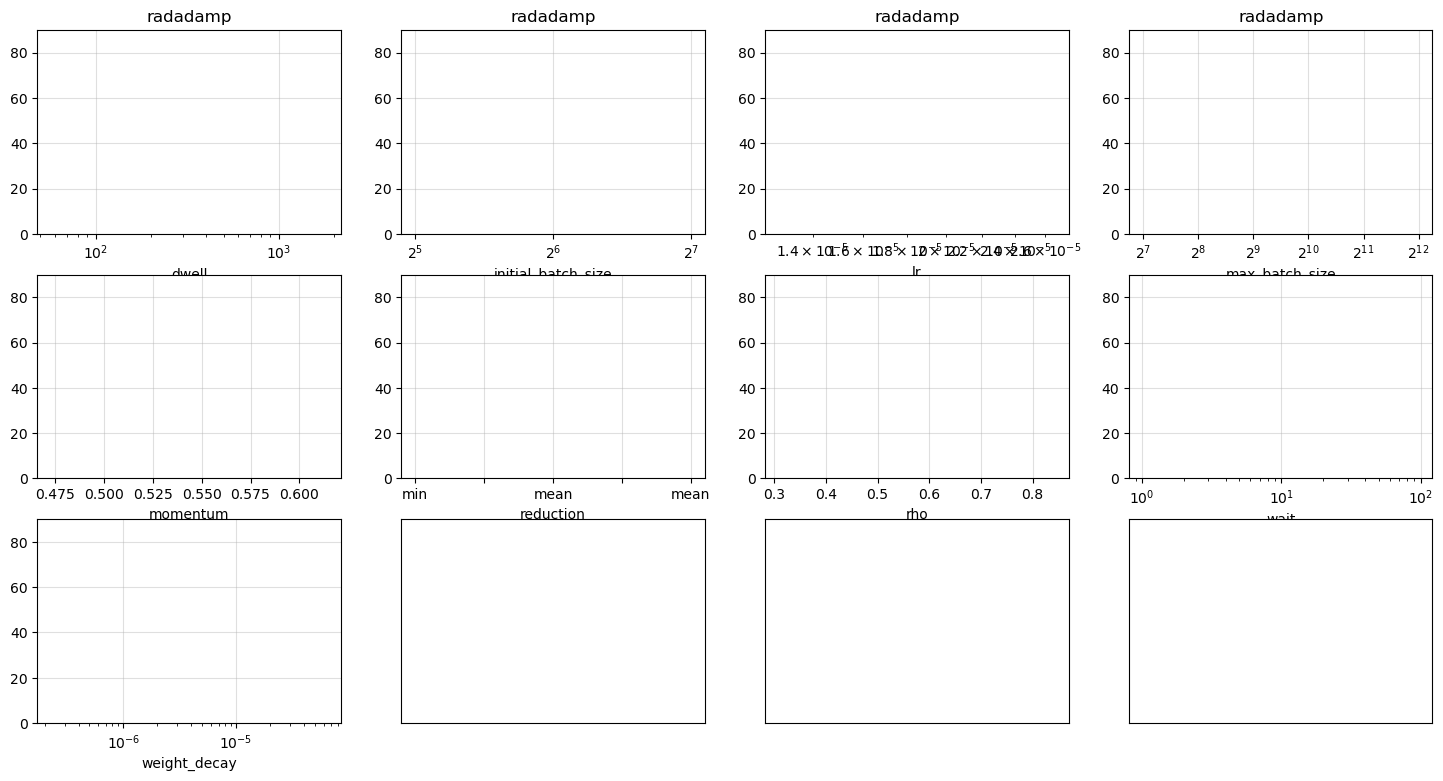

In [34]:
fig, axs, df = show("radadamp", cv_results)
DFS["radadamp"] = df

In [35]:
cv_results[cv_results.param_damper == "radadamp"].pivot_table(
    index="param_reduction",
    values="mean_test_score",
    aggfunc="mean",
)

,mean_test_score
param_reduction,
mean,-123.058920
min,-123.074299


['radadamplr']
min test/val loss 123.0226771515834


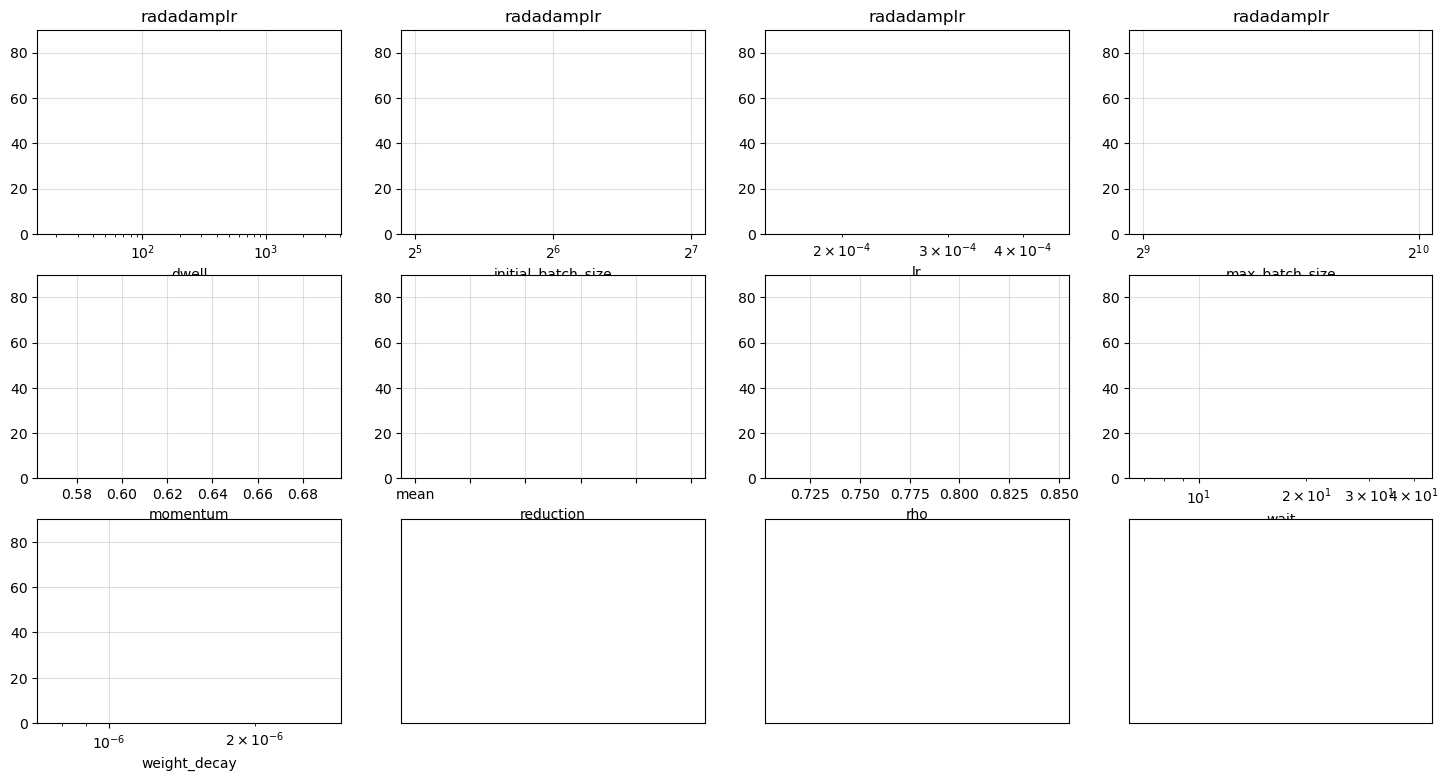

In [36]:
fig, axs, df = show("radadamplr", cv_results)
DFS["radadamplr"] = df

In [37]:
cv_results[cv_results.param_damper == "radadamplr"].pivot_table(
    index="param_reduction",
    values="mean_test_score",
    aggfunc="mean",
)

,mean_test_score
param_reduction,
mean,-123.053751
min,-123.022677


In [38]:
fig, axs, df = show("geodamp", cv_results)
DFS["geodamp"] = df

[]
min test/val loss nan


['geodamplr']
min test/val loss 123.23570054429429


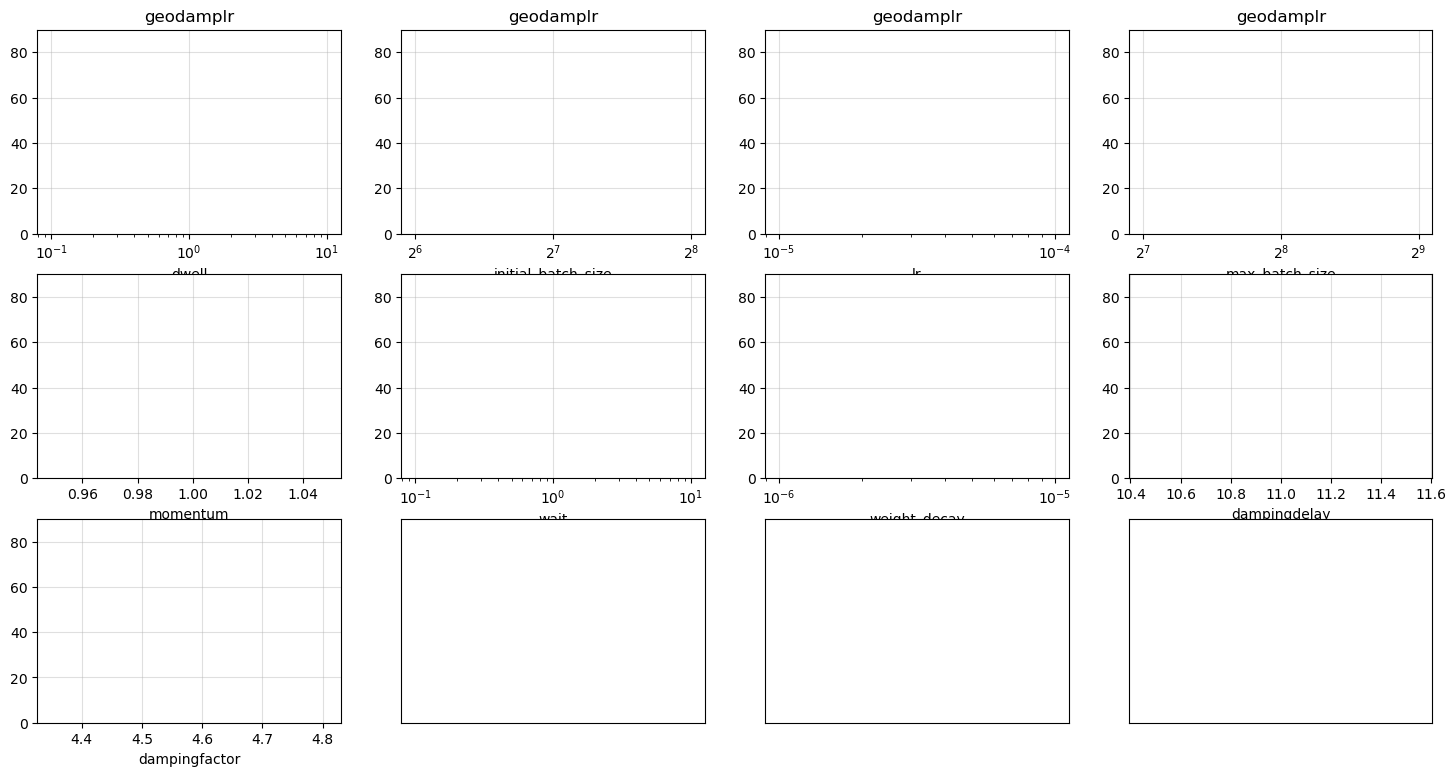

In [39]:
fig, axs, df = show("geodamplr", cv_results)

In [ ]:
fig, axs, df = show("adagrad", cv_results)

['adagrad']
min test/val loss 43.83448265381859


In [ ]:
fig, axs, df = show("adamw", cv_results)

In [21]:
fig, axs, df = show("gd", cv_results)

[]
min test/val loss nan


In [22]:
fig, axs, df = show("sgd", cv_results)

[]
min test/val loss nan


In [30]:
cv_results.param_damper.unique()

array(['padadamplr', 'padadamp', 'radadamplr', 'geodamp', 'adamw'],
      dtype=object)

In [31]:
from typing import Any
import numpy as np

def clean(x: Any):
    if isinstance(x, (np.float32, np.float64, np.int32, np.int64)):
        return x.item()
    elif isinstance(x, np.ndarray):
        return x.tolist()
    elif isinstance(x, list):
        return [clean(xi) for xi in x]
    elif isinstance(x, dict):
        return {k: clean(v) for k, v in x.items()}
    elif isinstance(x, tuple):
        return tuple(clean(list(x)))
    return x

def get_fname(params):
    params2 = [(k, params[k]) for k in sorted(list(params.keys()))]
    ident = "-".join(
        f"{k[:3]}={v:0.6e}" if isinstance(v, float) else f"{k[:3]}={v}"
        for k, v in clean(params2)
    )
    return ident

def find_match(ident, fnames):
    rare = [fname.replace(".pkl.zip", "") for fname in fnames]
    mrare = ["-".join(fname.split("-")[:-1]) for fname in rare]
    ids = ident.split("-")
    scores = [sum(x in ids for x in fname.split("-")) for fname in mrare]
    est_fname = mrare[np.argmax(scores)]
    scores2 = pd.Series(scores).value_counts()
    assert scores2[max(scores2.index)] == 1  # 3 random seeds
    return est_fname

def find_best_run(show: pd.DataFrame, damper: str, N_BEST=1):
    show = show.copy().reset_index()
    high_mean = show["mean_test_score"].nlargest(N_BEST).index
    best_models = show.loc[high_mean]
    idents = [get_fname(params) for params in best_models["params"].values]
    files = [f.name for f in RUNS.glob("*.pkl.zip")]
    est_fnames = [find_match(ident, files) for ident in idents]
    assert len(est_fnames) == N_BEST == 1
    ident = est_fnames[0]
    best_runs = [pd.read_pickle(f) for f in RUNS.glob("*.pkl.zip") if ident in f.name]
    ret = pd.concat(best_runs)
    ret["damper"] = damper
    return ret

best_runs = [
    find_best_run(cv_results[cv_results.param_damper == damper], damper)
    for damper in cv_results.param_damper.unique()
]
show_best = pd.concat(best_runs).reset_index()
show_best.damper.unique()

array(['padadamplr', 'padadamp', 'radadamplr', 'geodamp', 'adamw'],
      dtype=object)

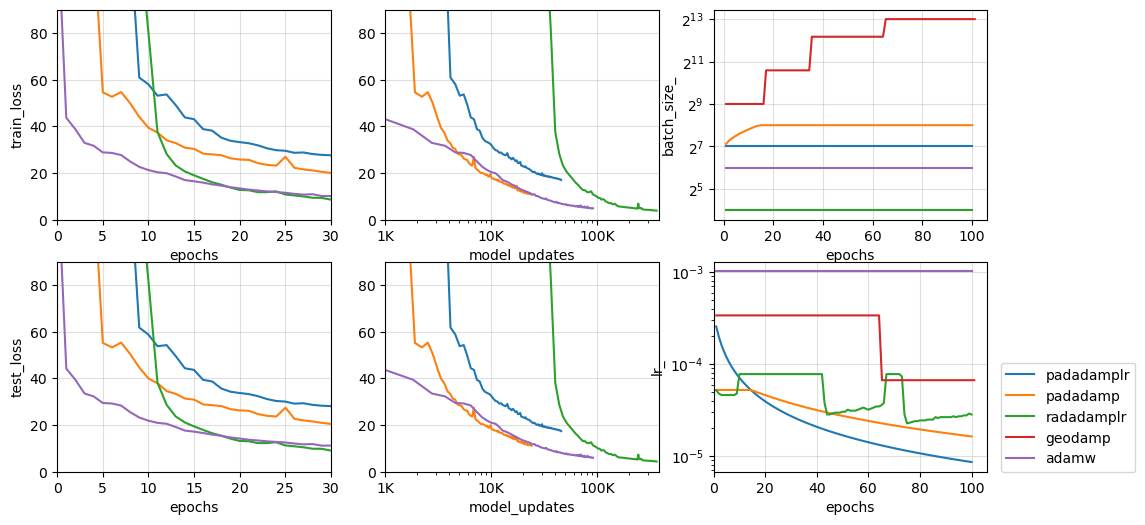

In [38]:
import seaborn as sns
w = 3
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(4.0 * w, 2.0 * w))
for i, loss in enumerate(["train_loss", "test_loss"]):
    for j, time in enumerate(["epochs", "model_updates"]):
        ax = sns.lineplot(
            x=time,
            y=loss,
            hue="damper",
            data=show_best,
            ax=axs[i][j],
        )
        ax.legend_.remove()
for i, (time, damping) in enumerate([("epochs", "batch_size_"), ("epochs", "lr_")]):
    ax = sns.lineplot(
        x=time,
        y=damping,
        hue="damper",
        data=show_best,
        ax=axs[i][2],
    )
    ax.set_yscale("log", base=2 if "batch" in damping else 10)
    if i == 1:
        ax.legend(loc=(1.05, 0))
    else:
        ax.legend_.remove()
    # if "updates" in time:
        # ax.set_xscale("log", base=10)
        # ax.set_xlim(10, 1000)#, 1_200)
    # else:
    #     ax.set_xlim(49, 51)
    
for i, ax in enumerate(axs.flatten()):
    ax.grid(alpha=0.4)
    if i != 2:
        ax.set_xlim(0, None)
    if i not in [0, 3, 2, 5]:
        ax.set_ylabel("")
    if i in [0, 1, 3, 4]:
        ax.set_ylim(0, 30)
    # BEGIN DEBUG
        ax.set_ylim(0, 90)
    if i in [0, 3]:
        ax.set_xlim(0, 30)
    if i in [1, 4]:
        ax.set_xlim(1_000, None)
        ax.set_xscale("log", base=10)
    # END DEBUG
    if i in [1, 4]:
        ax.xaxis.set_major_formatter(lambda x, _: f"{int(x / 1e3)}K")

In [36]:
dfs = [df for df in best_runs if set(df.damper.unique()) == {"geodamp"}]
print(len(dfs))
df = dfs[0]
from pprint import pprint
pprint(list(sorted(df.columns)))

2
['_epochs',
 '_num_examples',
 '_step_time',
 '_train_time',
 'approx_loss',
 'approx_rate',
 'batch_growth_rate',
 'batch_loss',
 'batch_size_',
 'damper',
 'damping',
 'dampingdelay',
 'dampingfactor',
 'dataset',
 'device_type',
 'dwell',
 'epoch_time',
 'epochs',
 'growth_rate',
 'ident',
 'init_seed',
 'initial_batch_size',
 'len_dataset',
 'len_test_x',
 'len_test_y',
 'len_train_x',
 'len_train_y',
 'loss_name',
 'lr',
 'lr_',
 'max_batch_size',
 'model_updates',
 'momentum',
 'nesterov',
 'no_cuda',
 'noisy',
 'num_examples',
 'num_params',
 'opt_name',
 'opt_param_dampening',
 'opt_param_differentiable',
 'opt_param_foreach',
 'opt_param_fused',
 'opt_param_lr',
 'opt_param_maximize',
 'opt_param_momentum',
 'opt_param_nesterov',
 'opt_param_weight_decay',
 'random_state',
 'reduction',
 'rho',
 'step_time',
 'test_accuracy',
 'test_device',
 'test_freq',
 'test_loss',
 'test_prefix',
 'test_x_sum',
 'test_y_sum',
 'time',
 'train_accuracy',
 'train_device',
 'train_loss',
 

<Axes: xlabel='epochs'>

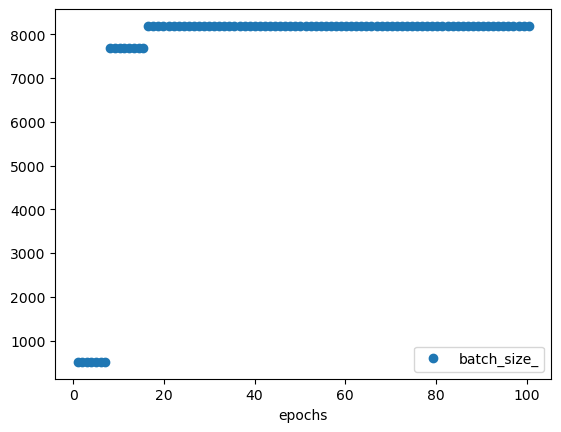

In [42]:
df.plot(
    x="epochs",
    y="batch_size_",
    style="o",
)

In [70]:
# damper = "adagrad"
# damper = "geodamp"
# damper = "padadamp"
# damper = "sgd"
# damper = "geodamplr"
# damper = "padadamp"
# damper = "gd"
# damper = "padadamplr"
# damper = "geodamp"

DATA = Path(".") / "data-tuning2"

SEARCHES = DATA / "searches"
SEARCHES = DATA / "dampersearch"
RUNS = DATA / "dampersweep"
searches = [pickle.loads(f.read_bytes()) for f in SEARCHES.glob(f"search-{damper}-*.pkl")]
print("Number of searches:", len(searches))
cv_results = pd.concat([pd.DataFrame(s.cv_results_) for s in searches]).reset_index()
if damper == "padadamp":
    cv_results = cv_results[cv_results.param_growth_rate >= 1e-3]
print("Number of models:", len(cv_results))
print("Min test loss: {:0.3f}".format(-1 * cv_results.mean_test_score.max()))
# print("Number of models:", len(cv_results))

Number of searches: 9
Number of models: 225
Min test loss: 1.268


In [71]:
cv_results.tail()

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_damper,param_dwell,param_initial_batch_size,param_lr,param_max_batch_size,param_momentum,param_nesterov,param_weight_decay,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
220,20,10847.940768,259.732508,0.000254,0.000022,adadampnn,1.283468,16,0.000195,2048,0.994143,True,1.571346e-06,"{'damper': 'adadampnn', 'dwell': 1.28346835710...",-2.392683,-3.097961,-2.377299,-2.622648,0.336156,12
221,21,2719.884434,71.216713,0.000274,0.000014,adadampnn,3.672424,16,0.000082,256,0.974085,True,1.869023e-07,"{'damper': 'adadampnn', 'dwell': 3.67242437089...",-1.360107,-1.389930,-1.337926,-1.362654,0.021307,6
222,22,414.957711,121.787614,0.000324,0.000032,adadampnn,41.737214,16,0.003944,512,0.970962,True,1.247866e-06,"{'damper': 'adadampnn', 'dwell': 41.7372140347...",-4.141165,-4.101789,-4.105239,-4.116064,0.017804,23
223,23,1083.548179,22.692486,0.000286,0.000006,adadampnn,8.409901,64,0.000056,8192,0.993994,True,1.921671e-07,"{'damper': 'adadampnn', 'dwell': 8.40990117357...",-1.340458,-1.352873,-1.339604,-1.344312,0.006064,3
224,24,167.907637,87.321306,0.000374,0.000019,adadampnn,6.573215,32,0.070985,512,0.981136,True,3.720989e-05,"{'damper': 'adadampnn', 'dwell': 6.57321511459...",-4.092317,-4.099634,-4.107913,-4.099955,0.006371,19


# Visualizing param performance

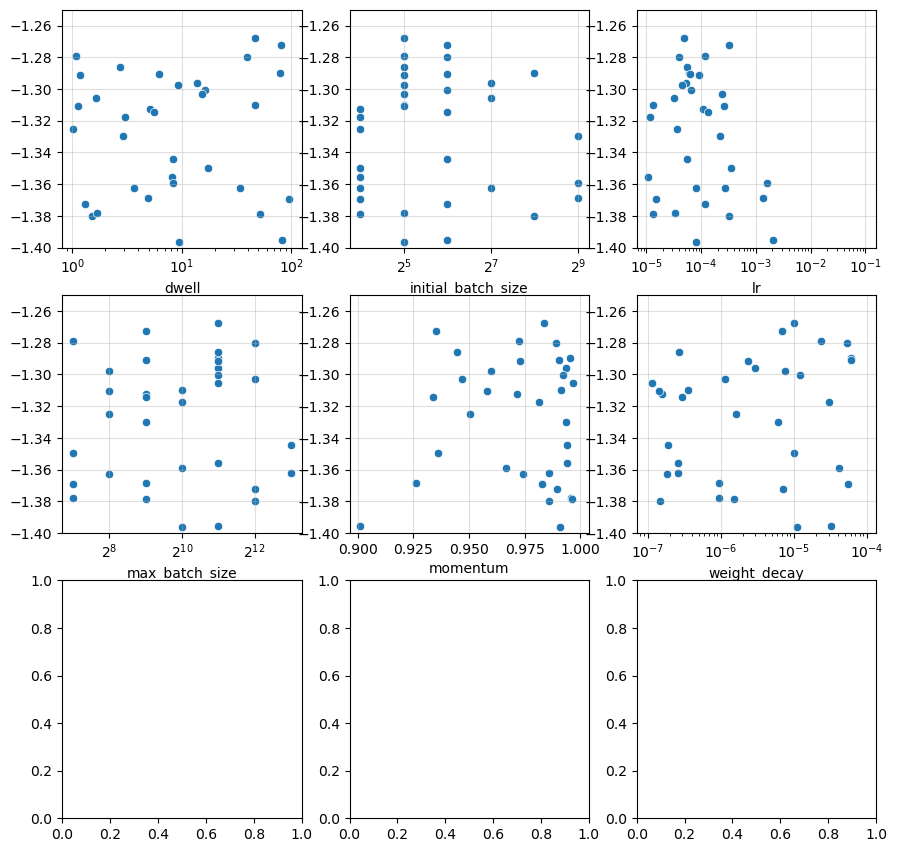

In [72]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

w = 3
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(3.5 * w, 3.5 * w))

params = [c for c in cv_results.columns if "param_" in c]
params = [c for c in params if "damper" not in c and "nesterov" not in c and "reduction" not in c]
for c, ax in zip(params, axs.flatten()):
    ax = sns.scatterplot(
        x=c,
        y="mean_test_score",
        ax=ax,
        data=cv_results,
    )
    ax.set_xlabel(c.replace("param_", ""))
    ax.set_ylim(-1.4, -1.25)
    ax.grid(alpha=0.4)
    if "batch_size" in c:# or "dwell" in c: 
        ax.set_xscale("log", base=2)
    if "lr" in c or  "weight_decay" in c or "wait" in c or "dwell" in c or "growth_rate" in c:
        ax.set_xscale("log", base=10)
    ax.set_ylabel("")

# {
#     "dwell": loguniform(10, 50),
#     "initial_batch_size": [16, 32, 64, 96, 128],
#     # "lr": loguniform(1e-5, 1e-3),
#     "max_batch-size": [256, 512, 1024, 2048],
#     "momentum": uniform(1e-3, 0.8),
#     "reduction": ["min"],
#     # "rho": uniform(0, 0.99),
#     # "wait": loguniform(20, 1e3),
#     # "weight_decay": loguniform(1e-7, 1e-5),
# }

# Showing fit time/score std vs. score

In [84]:
N_BEST = 7

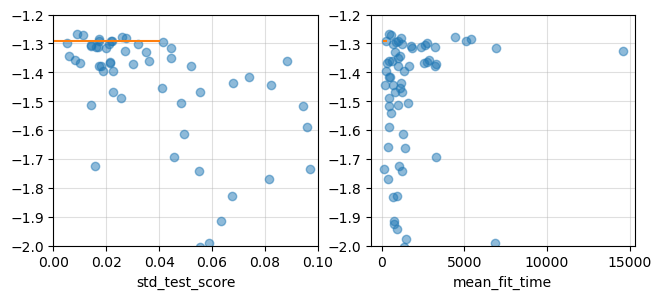

In [85]:
high_mean = cv_results["mean_test_score"].nlargest(N_BEST).index
cutoff = cv_results.loc[high_mean, "mean_test_score"].min()
low_std = cv_results["std_test_score"].nsmallest(N_BEST).index

best_models = cv_results.loc[high_mean]

# best_models[[c for c in best_models.columns if "param" not in c]]
w = 3
fig, axs = plt.subplots(ncols=2, figsize=(2.5 * w, w))
ax = cv_results.plot(
    y="mean_test_score",
    x="std_test_score",
    style="o", ax=axs[0],
    alpha=0.5,
)
ax.plot([0, 0.04], [cutoff, cutoff])
ax.set_xlim(0, 0.1)
ax.set_xlabel("std_test_score")

ax = cv_results.plot(
    y="mean_test_score",
    x="mean_fit_time",
    style="o", ax=axs[1],
    alpha=0.5,
)
ax.plot([100, 280], [cutoff, cutoff])
# ax.set_xscale("log", base=10)

for ax in axs.flatten():
    ax.grid(alpha=0.4)
    ax.set_ylim(-2.0, -1.2)
    ax.legend_.remove()

# Showing `N_BEST` best params
See above for `N_BEST` definition.

In [86]:
best_models.mean_test_score

53    -1.267539
171   -1.272411
75    -1.278864
5     -1.279965
99    -1.285952
60    -1.289940
189   -1.290705
Name: mean_test_score, dtype: float64

In [87]:
from typing import Any
import numpy as np

def clean(x: Any):
    if isinstance(x, (np.float32, np.float64, np.int32, np.int64)):
        return x.item()
    elif isinstance(x, np.ndarray):
        return x.tolist()
    elif isinstance(x, list):
        return [clean(xi) for xi in x]
    elif isinstance(x, dict):
        return {k: clean(v) for k, v in x.items()}
    elif isinstance(x, tuple):
        return tuple(clean(list(x)))
    return x
    
def get_fname(params):
    params2 = [(k, params[k]) for k in sorted(list(params.keys()))]
    ident = "-".join(
        f"{k[:3]}={v:0.6e}" if isinstance(v, float) else f"{k[:3]}={v}"
        for k, v in clean(params2)
    )
    return ident

def find_match(ident, fnames):
    rare = [fname.replace(".pkl.zip", "") for fname in fnames]
    mrare = ["-".join(fname.split("-")[:-1]) for fname in rare]
    ids = ident.split("-")
    scores = [sum(x in ids for x in fname.split("-")) for fname in mrare]
    est_fname = mrare[np.argmax(scores)]
    scores2 = pd.Series(scores).value_counts()
    assert scores2[max(scores2.index)] == 3  # 3 random seeds
    return est_fname

idents = [get_fname(params) for params in best_models["params"].values]
files = [f.name for f in RUNS.glob("*.pkl.zip")]
est_fnames = [find_match(ident, files) for ident in idents]
est_fnames

best_runs = {ident: [pd.read_pickle(f) for f in RUNS.glob("*.pkl.zip") if ident in f.name] for ident in est_fnames}
k = list(best_runs.keys())[0]
print(len(best_runs[k]))
len(best_runs)

3


7

len(show) = 303


/tmp/ipykernel_3599267/464595921.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=(1.05, 0))


len(show) = 301


/tmp/ipykernel_3599267/464595921.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=(1.05, 0))


len(show) = 303


/tmp/ipykernel_3599267/464595921.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=(1.05, 0))


len(show) = 303


/tmp/ipykernel_3599267/464595921.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=(1.05, 0))


len(show) = 303


/tmp/ipykernel_3599267/464595921.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=(1.05, 0))


len(show) = 301


/tmp/ipykernel_3599267/464595921.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=(1.05, 0))


len(show) = 302


/tmp/ipykernel_3599267/464595921.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=(1.05, 0))


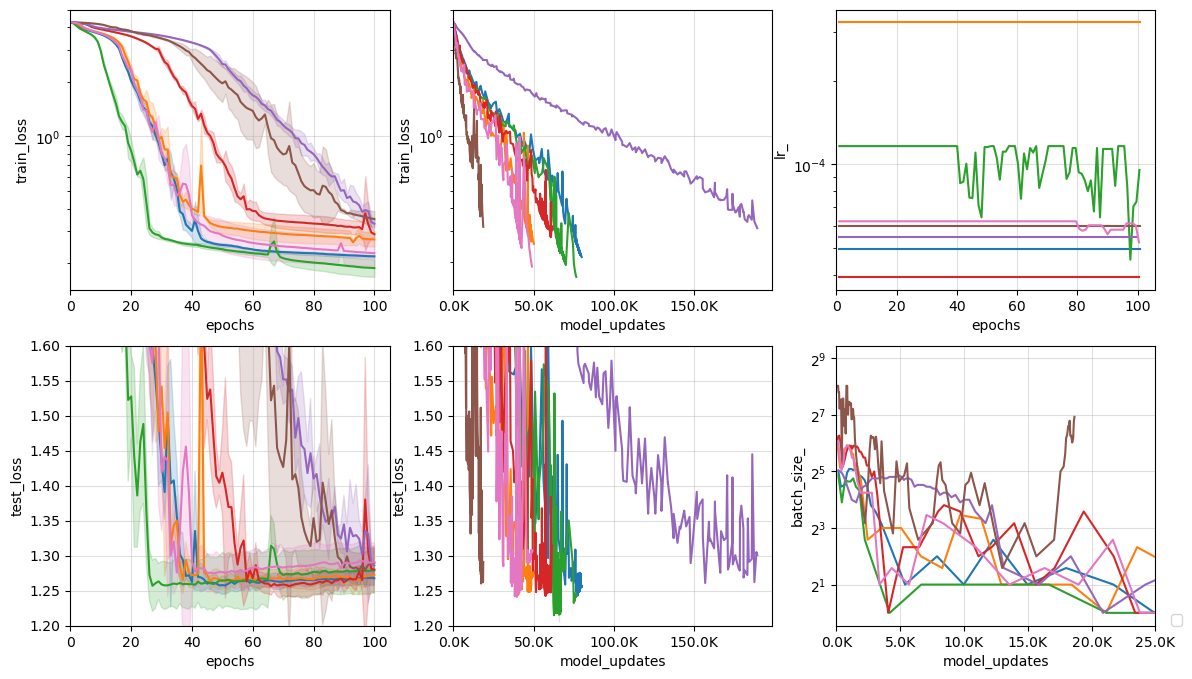

In [92]:
w = 4
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3.5 * w, 2 * w))
for ident, _dfs in best_runs.items():
    show = pd.concat(_dfs).reset_index()
    show["epochs"] = show["epochs"].astype(int)
    print("len(show) =", len(show))
    # show["model_updates"] = ((show["model_updates"] * 1000).astype(int)) / 1000
    kwargs = dict(data=show, estimator="mean", errorbar="sd")
    # kwargs = dict(data=_dfs[0], errorbar="sd")
    # _df = pd.concat(_dfs)
    for i, loss in enumerate(["train_loss", "test_loss"]):
        for j, time in enumerate(["epochs", "model_updates"]):
            #ax = sns.lineplot(x=time, y=loss, ax=axs[i][j], **kwargs)
            ax = sns.lineplot(x=time, y=loss, ax=axs[i][j], **kwargs)
            if "test" in loss:
                ax.set_ylim(1.2, 1.6)
            if "train" in loss:
                ax.set_yscale("log")
                
            if "updates" in time:
                ax.xaxis.set_major_formatter(lambda x, _: f"{x / 1e3}K")
                # ax.set_xlim(0, 10_000 if "geodamp" not in damper else 3_000)
            # if "epochs" in time:
            #     ax.set_xlim(0,200)
            # ax.set_xlim(0, None)
                # ax.set_xscale("log", base=10)
                # ax.set_xlim(10_000, None)
    for i, (time, var) in enumerate([("epochs", "lr_"), ("model_updates", "batch_size_")]):
        # kwargs = dict(label=ident) if i == 1 else {}
        kwargs = dict(errorbar="sd")
        ax = sns.lineplot(x=time, y=var, data=_dfs[2], ax=axs[i][2], **kwargs)
        if i == 1:
            ax.legend(loc=(1.05, 0))
        ax.set_yscale("log", base=2 if "batch" in var else 10)
        if "updates" in time:
            ax.xaxis.set_major_formatter(lambda x, _: f"{x / 1e3}K")
            ax.set_xlim(0, 25_000)
        # if "epochs" in time:
            # ax.set_xscale("log", base=10)
for ax in axs.flatten():
    ax.grid(alpha=0.4)
    ax.set_xlim(0, None)

- padadamplr: 1.325ish after 2K mu
- padadamp: 1.32ish after ~1.8K mu (batch size didn't grow fast, only up by a factor of 2 from 256 to 512)
- geodamp: 1.27ish after 3K mu (and 1.29ish after 500 mu), 20 epochs
- geodamplr: 20 epochs, at least 4K mu
- adagrad: 1.25 after 2K model updates / 100 epochs
- sgd: 1.30ish 4K mu and 100 epochs

In [56]:
best_params = best_models[[c for c in best_models.columns if "param_" in c]]
np.log10(best_params["param_growth_rate"]).plot.hist()

KeyError: 'param_growth_rate'

In [11]:
rate = best_models.param_growth_rate
ibs = best_models.param_initial_batch_size
updates = 10_000
bs = ibs * (1 + rate * updates)
bs

23    150768.628637
24       958.100722
14      3019.859957
16     27698.548082
22     37857.016517
dtype: float64